In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities  import  WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wwrp_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wwrp_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogr'

In [4]:
api_wwraper_wikipedia=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wwraper_wikipedia)
wiki.name

'wikipedia'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Dell\AppData\Local\Temp\ipykernel_10252\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [7]:
tavily.invoke("Provide me the recent AI news?")

[{'title': 'AI News & Artificial Intelligence - TechCrunch',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': '### [Scale AI confirms ‘significant’ investment from Meta, says CEO Alexandr Wang is leaving](https://techcrunch.com/2025/06/13/scale-ai-confirms-significant-investment-from-meta-says-ceo-alexandr-wang-is-leaving/)\n\n![dripping Facebook Meta logo](https://techcrunch.com/wp-content/uploads/2021/12/dripping-meta-logo.jpg?w=668)\n\n### [The Meta AI app is a privacy disaster](https://techcrunch.com/2025/06/12/the-meta-ai-app-is-a-privacy-disaster/) [...] ### [Spiraling with ChatGPT](https://techcrunch.com/2025/06/15/spiraling-with-chatgpt/)\n\n![Huawei Sign at MWC 2023](https://techcrunch.com/wp-content/uploads/2023/02/20230228_162746.jpg?w=500)\n\n### [Taiwan places export controls on Huawei and SMIC](https://techcrunch.com/2025/06/15/taiwan-places-export-controls-on-huawei-and-smic/)\n\n![Google sign](https://techcrunch.com/wp-content/uploads/20

In [8]:
## combine all these tools in the list
tools=[arxiv, wiki, tavily]

In [9]:
## Initialize the LLM Model
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

In [10]:
llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, the user is asking "What is AI?" I need to explain it in simple terms. Let me start by defining AI as a branch of computer science. I should mention that it\'s about making machines perform tasks that typically require human intelligence. Then I should break down the key areas of AI. Machine learning is important—maybe explain that it\'s about learning from data. Also, mention subfields like natural language processing and computer vision. It\'s good to give examples like virtual assistants and recommendation systems to make it relatable. I should touch on how AI works, maybe talk about data, algorithms, and training. Don\'t forget to note that AI can be categorized as narrow or general, and mention ethical considerations like bias and privacy. Keep it clear and avoid jargon so it\'s easy to understand.\n</think>\n\nArtificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to perform tasks that typica

In [11]:
llm_with_tools=llm.bind_tools(tools=tools)

In [12]:
## Execute this call
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qkvqqdbfd', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 239, 'prompt_tokens': 270, 'total_tokens': 509, 'completion_time': 0.597131943, 'prompt_time': 0.067179844, 'queue_time': 2.633945036, 'total_time': 0.664311787}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--40d7a6c5-5148-4bfb-b803-6ffe46729429-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'qkvqqdbfd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 270, 'output_tokens': 239, 'total_tokens': 509})

In [13]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated  ## labelling
from langgraph.graph.message import add_messages  ## Reducers in Langgraph

In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

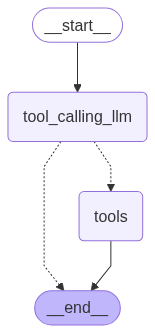

In [16]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (znjtrve9g)
 Call ID: znjtrve9g
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [18]:
messages=graph.invoke({"messages":"Hi My name is Krish"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Krish
================================== Ai Message ==================================

Hello Krish! Nice to meet you. How can I assist you today? If you have any questions or need help with anything—like looking up research papers, finding information from Wikipedia, or searching the web—just let me know! 😊


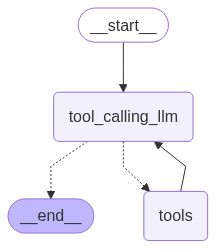

In [19]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
messages=graph.invoke({"messages":"What is the recent AI news and then please tell me the recent research paper on quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and then please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9w67m08z2)
 Call ID: 9w67m08z2
  Args:
    query: recent AI news
  arxiv (xekhpmf6y)
 Call ID: xekhpmf6y
  Args:
    query: recent research paper on quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "Hugging Face partners with Groq for ultra-fast AI model inference · Meta buys stake in Scale AI, raising antitrust concerns · Ericsson and AWS bet on AI to", "score": 0.71185225}, {"title": "Artificial Intelligence | Latest News, Photos & Videos - WIRED", "url": "https://www.wired.com/tag